In [1]:
import re

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy


![alt text](map.jpg "Схема GPS")

# Агрохимия 

In [2]:
agrochemistry_total = pd.read_csv('полевые данные общая/ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns

Index(['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Общий углерод, %',
       'М.д. содержания  гипса (по Хитрову), %',
       'Массовая доля иона хлорида, ммоль/100 г',
       'Массовая доля иона сульфата, ммоль/100 г',
       'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
       'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы',
       'Сумма поглощенных оснований по Каппену, ммоль/100 г',
       'Массовая доля плотного остатка водной вытяжки, %',
       'Карбонат и бикарбонат-ионы, ммоль/100 г',
       'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
       'Массовая доля общего содержания карб

### Агрохимические показатели по пахатному горизонту

In [3]:
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']
agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)


In [4]:

def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property_ = re.sub(r'[\(),.%№ /-]', '' , agrochem_property)
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )
    reg = ols('{} ~ Год + Глубина  +  Типобработки + GPS'.format(agrochem_property_) ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible, agrochem_property):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth[agrochem_property][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))
    if len(df[hue].unique()) == 2:
        pal =  "prism_r"
    else:
        pal =  "tab10"
    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        palette = pal,
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1" ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    features = ['Год', 'GPS №', 'Тип обработки', 'Глубина']
    features.append(agrochem_property) #добавление фичи
    df = df[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df, agrochem_property)
    stat_test_df = anova(df, type_, agrochem_property)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


#### отобрали данные

описательные статистики

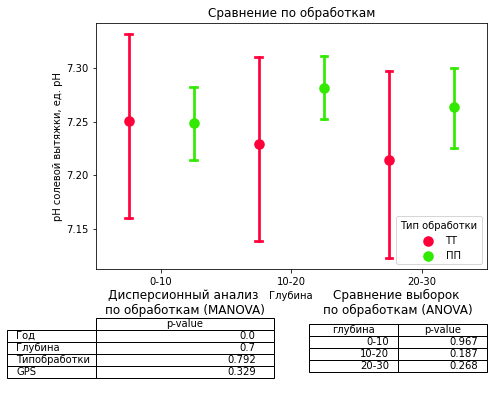

In [5]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

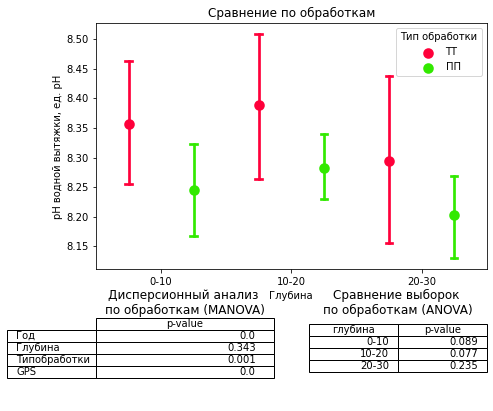

In [6]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

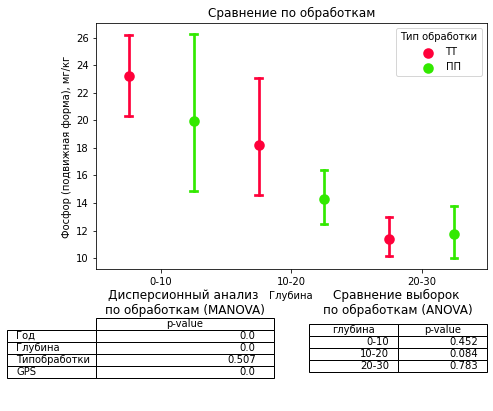

In [7]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

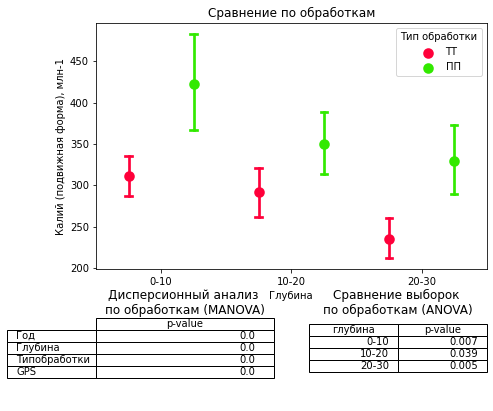

In [8]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

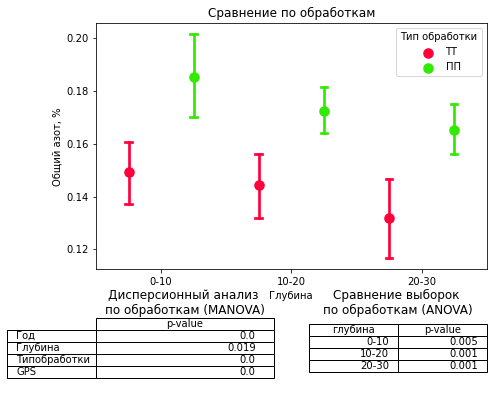

In [9]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Общий азот, %', to_lable = "обработкам")

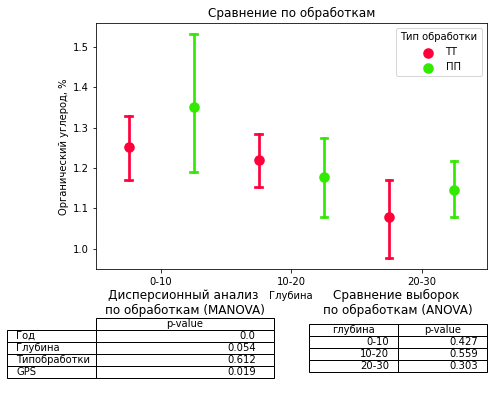

In [10]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

In [11]:
pp_points = ["525","526","527","528","586"]
by_points = agrochemistry_main[agrochemistry_main["GPS №"].isin(pp_points)]

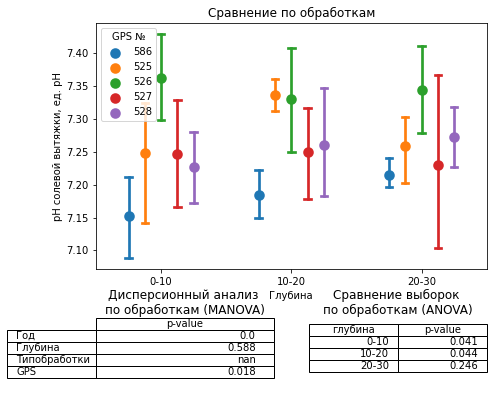

In [12]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

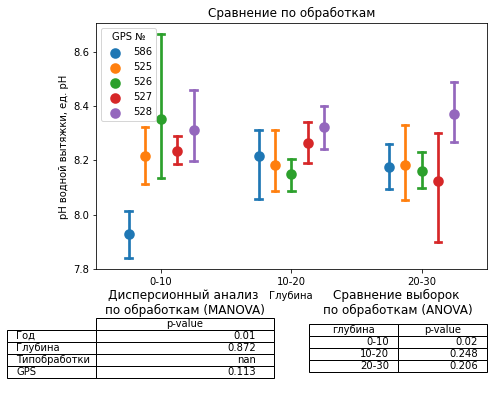

In [13]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

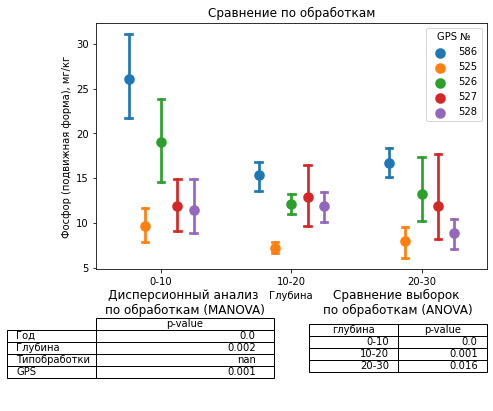

In [14]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

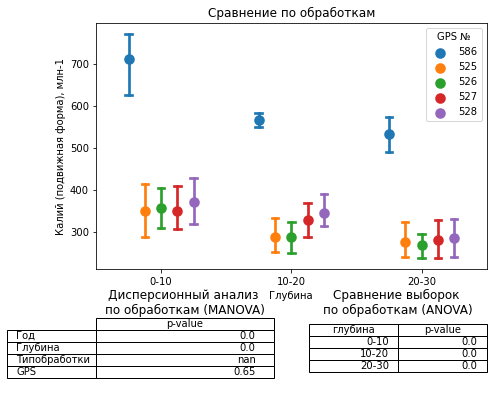

In [15]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

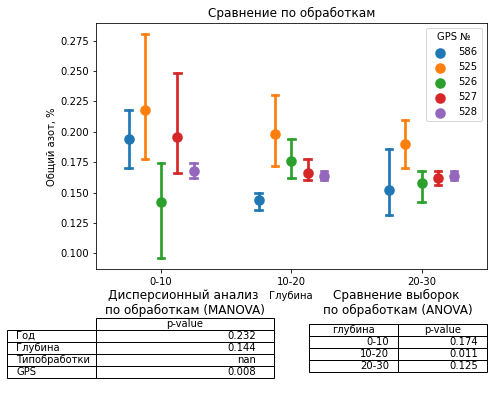

In [16]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Общий азот, %', to_lable = "обработкам")

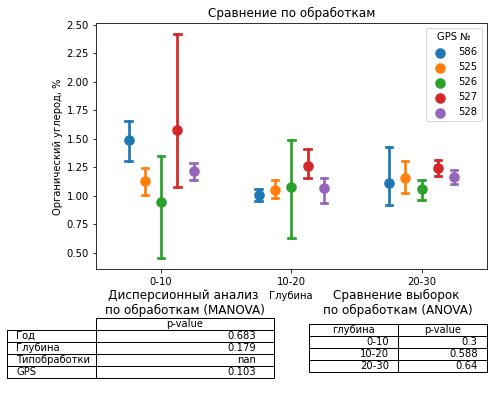

In [17]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

получилось все сделать тут надо допилить фоном обеспеченность 

Почвенные профили - код готов следующее это посмотреть в учебнике на работе какие профили надо использовать 

In [18]:
sample = agrochemistry_total[agrochemistry_total["GPS №"] == '525']
sample['depth'] = sample["Глубина"].str.split('-', expand=True)[0]
sample['depth'] = sample['depth'].astype(int)


<ipython-input-18-7861f9fdb64c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['depth'] = sample["Глубина"].str.split('-', expand=True)[0]
<ipython-input-18-7861f9fdb64c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['depth'] = sample['depth'].astype(int)


In [73]:
agrochem_features = [  'М.д. содержания  гипса (по Хитрову), %','Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)','Органический углерод, %']
agrochem_features_labs = ["Гипс, %", "Карботнаты, %", "Орг. Углерод, %" ]
horizonts = ['A',"B" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]
def profile_plot(sample,agrochem_features,agrochem_features_labs, horizonts,depth, colors,plotname ):

    plot_num = len(agrochem_features)
    sizes = [1] * plot_num
    sizes.append( 0.5)
    hr = {'height_ratios': sizes}
    fig, ax  = plt.subplots(plot_num + 1,1, figsize = (10,plot_num * 2), gridspec_kw=hr )

    sns.lineplot(data =sample, y ='Органический углерод, %' , x = "depth" ,alpha = 0,ci=None, ax = ax[-1])
    ax[-1].set( ylabel ='Горизонт', yticks =[]  )
    ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[-1].set_xlabel('глубина', rotation = 180)
    ax[-1].set_title('№ скважины {}'.format(plotname), fontsize = 16, rotation = 90, x = -0.1, y = 2)

    for hor in range(len(horizonts)):
        ax[-1].fill_between(x =depth[hor],y1 = 2, color=colors[hor], alpha=0.7)
        text_position = (depth[hor][1] - depth[hor][0])/2 + depth[hor][0]
        ax[-1].text(x = text_position , y = 0.6, s = horizonts[hor],size = 16,weight='bold' , rotation = 90)


    for num, prop in enumerate(agrochem_features):
        sns.lineplot(data =sample, y =prop , x = "depth" ,color = 'black', ci=None, ax = ax[num])
        ax[num].set(xticks=[], xlabel=None, ylabel =agrochem_features_labs[num] )
        ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
        for line in depth:
            ax[num].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")







<ipython-input-73-cc7606022804>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
<ipython-input-73-cc7606022804>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-73-cc7606022804>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-73-cc7606022804>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)


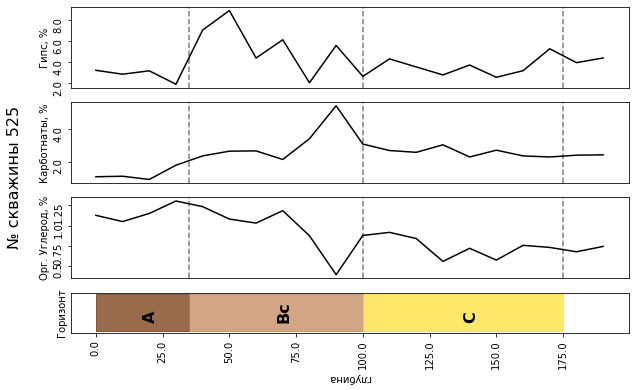

In [74]:
agrochem_features = [  'М.д. содержания  гипса (по Хитрову), %','Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)','Органический углерод, %']
agrochem_features_labs = ["Гипс, %", "Карботнаты, %", "Орг. Углерод, %" ]
horizonts = ['A',"Bc" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]

profile_plot(sample,agrochem_features,agrochem_features_labs, horizonts,depth, colors,'525' )

Распределение растворимых солей по профилю 

In [71]:
def salts_profile(salts_df,plotname):
        salts_type = salts.columns[1:-1]
        salts_labs = [
                'М.д. хлор.\nммоль/100 г',
                'М.д. сульф.\nммоль/100 г',
                'М.д. Mg\nммоль/100 г',
                'М.д. Ca\nммоль/100 г',
                'М.д. Na\nмг•экв/100 г',
                'М.д. K\nмг•экв/100 г']

        fig, ax  = plt.subplots( len(salts_labs) + 1,1, figsize = (10,14))





        for num, prop in enumerate(salts_type):
                sns.lineplot(data =salts_df, y =prop , x = "depth" ,color = 'black', ci=None, ax = ax[num])
                ticks = ax[num].get_xticks()
                ax[num].set(xticks=[], xlabel=None, ylabel =salts_labs[num] )
                ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)

        sns.lineplot(data =salts_df, y ='Массовая доля плотного остатка водной вытяжки, %' , x = "depth" ,color = "black",ci=None, ax = ax[-1])
        ax[-1].set( ylabel ='М.д. плот.ост.\n%'  )

        ax[-1].set_xticklabels(ticks, rotation = 90)
        ax[-1].set_xlabel('глубина', rotation = 180)


        ax[-1].set_title('№ скважины {}'.format(plotname), fontsize = 16, rotation = 90, x = -0.1, y = 2)


<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
<ipython-input-71-c23839cf1d92>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[num].set_ytick

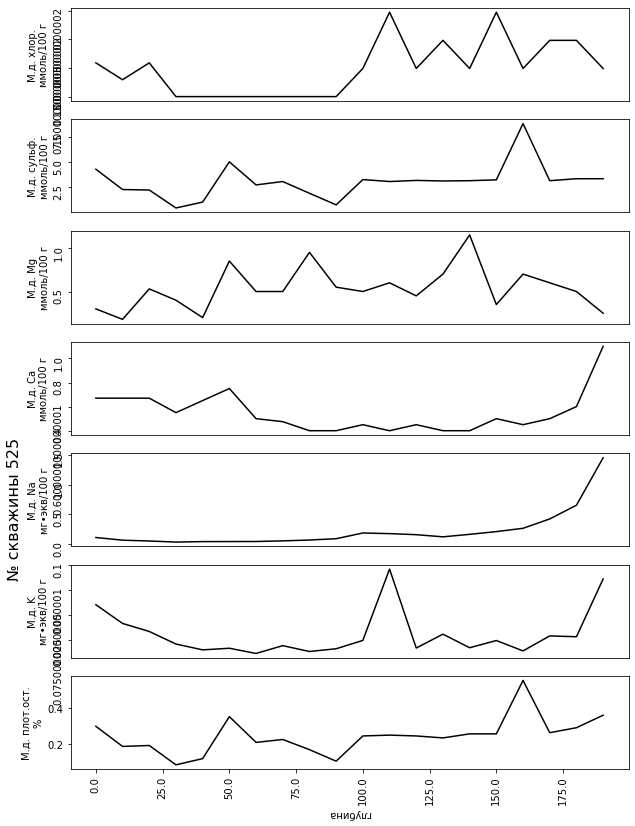

In [72]:
salts_profile(sample , '525')